# The holism of machine learning and preprocessing your data

by Hugo Bowne-Anderson

Data preprocessing is an umbrella term that covers an array of operations data scientists will use to get their data into a form more appropriate for what they want to do with it. For example, before performing sentiment analysis of twitter data, you may want to strip out any html tags, white spaces, expand abbrevations and split the tweets into lists of the words they contain. When analyzing spatial data you may scale it so that it is unit-independent, that is, so that your algorithm doesn't care whether the measurements are in metres or microns. However, preprocessing data does not occur in a vacuum. This is just to say that preprocessing is a means to an end and there are no hard and fast rules: there are standard practices, as we shall see, and you can develop an inutition for what will work but, in the end, preprocessing is generally part of a results-oriented pipeline and its performance needs to be judged in context.

In this article, we'll use the example of scaling numerical data in a variety on contexts to elucidate the importance of considering preprocessing as part of a greater structure, the machine learning pipeline. We'll see real-world examples in which scaling can improve model performance and examples in which it doesn't so much. We'll also synthesize an example dataset and see the same principles at play.

We'll first introduce classification problems and K-nearest neighbours, one of the simplest algorithms used in such settings. To appreciate the importance of scaling numerical data in such a setting, we'll need to introduce measures of model performance and the concept of training and test sets. We'll see all these concepts & practices at play with a dataset in which we attempt to classify the quality of red wine. We'll then introduce regression and show that, in its logistic incarnation, regression can be used in classification problems, such as the wine dataset. We'll see that scaling performs very differently in this scenario, even though the question is the same. We'll then wrap up seeing all these issues at play with a synthesized dataset. I'll also make sure that we put preprocessing in its most useful place, near the beginning of an iterative data science pipeline.

### A brief introduction to classification

Classifying and labelling things in the phenomenal world is an ancient art. In the modern world, it is commonly framed as a machine learning task, in particular, a supervised learning task. The basic principle of supervised learning is straightforward: we have a bunch of data consisting of predictor variables and a target variable. The aim of **supervised learning** is to build a model that is 'good at' predicting the target variable, given the predictor variables. If the target variable consists of categories (e.g. 'click' or 'not', 'malignant' or 'benign' tumour), we call the learning task **classification**. Alternatively, if the target is a continuously varying variable (e.g. price of a house), it is a **regression** task. 

An illustrative example will go a long way here: consider the <a href='http://archive.ics.uci.edu/ml/datasets/Heart+Disease'>heart disease dataset</a>, in which there are 75 predictor variables, such as 'age', 'sex', 'smoker' or 'not' and the target variable refers to the presence of heart disease and ranges from 0 (no heart disease) to 4. Much work on this dataset has concentrated on attempts to distinguish the presence of heart disease from its absence. This is a classification task. If you were to attempt to predict the actual value (0 to 4) of the target variable, this would be a regression problem. We'll discuss regression in brief below. Here we'll look at one of the simplest algorithms for classification tasks, the **K-nearest neighbours algorithm**.

#### K-nearest neighbours

Let's say that we have some labeled data, for example, data that consists of characteristics of red wine (e.g. alcohol content, density, amount of citric acid, pH, etc...; these are the predictor variables) with target variable 'Quality' and labels 'good' & 'bad'. Then, given the characteristics of a new, unlabeled wine, the classification task is to predict its 'Quality'. When all the predictor variables are numerical (there are also ways to deal with the categorical case), we can consider each row/wine as a point in n-dimensional space and, in this case, k-nearest neighbours is a conceptually & computationally simple classification method: for each new, unlabeled wine, we calculate, for some integer k, its k nearest neighbours in the n-dimensional predictor variable space. Then we look at the labels of these k neighbours (i.e. 'good' or 'bad') & assign the label with the most hits to the new wine (e.g. if k = 5, 3 neighbours vote 'good' and 2 vote 'bad', then our model labels the new wine 'good').

In [1]:
from IPython.display import Image
Image(url= 'http://36.media.tumblr.com/d100eff8983aae7c5654adec4e4bb452/tumblr_inline_nlhyibOF971rnd3q0_500.png')

#### K-NN implementation (sklearn)

Let's now see an example of K-NN at work. To do so, we'll check out the wine quality dataset (http://archive.ics.uci.edu/ml/datasets/Wine+Quality): we'll import it into a pandas dataframe and then plot histograms of the predictor variables to get a feel for the data:

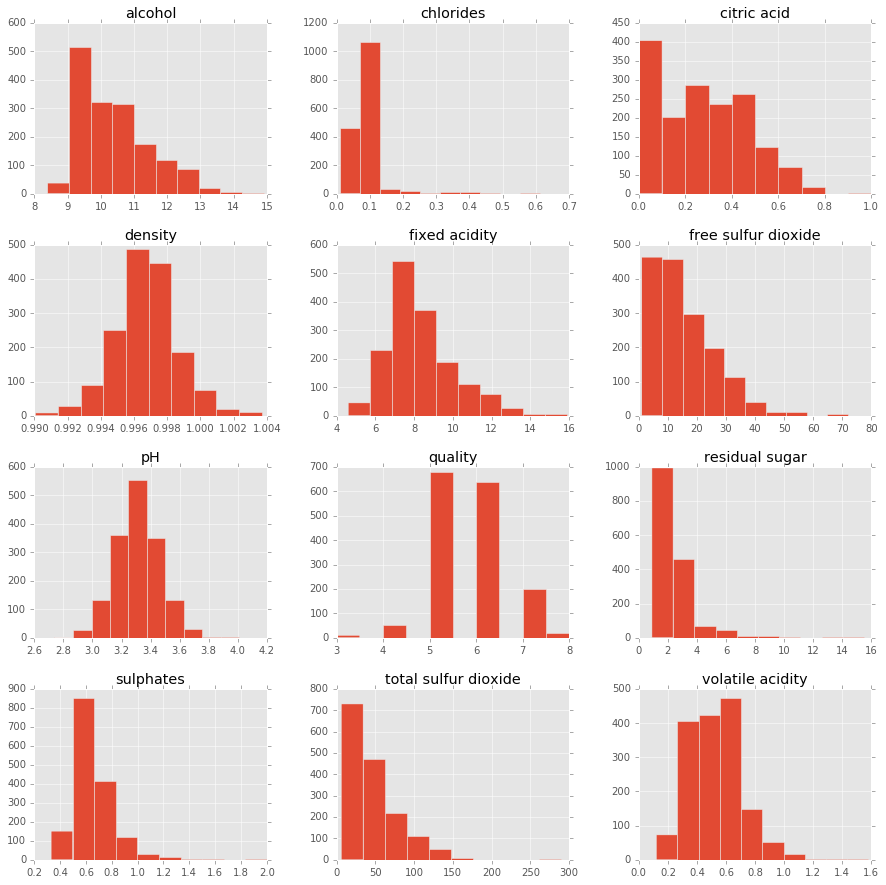

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df = pd.read_csv('wine_quality/winequality-red.csv' , sep = ';')
X = df.drop('quality' , 1).values #drop target variable
y1 = df['quality'].values
pd.DataFrame.hist(df, figsize = [15,15]);

First notice the range of the predictor variables: 'free sulfur dioxide' ranges from 0 to ~70 and volatile acidity from ~0 to ~1.2. More specifically, the former has a range 2 orders of magnitude larger than that of the latter. Any algorithm, such as K-NN, which cares about the distance between data points, may thus focus squarely and unfairly on variables with a larger range, such as 'free sulfur dioxide', a variable that may only be contain noise, for all we know. This motivates scaling our data, which we'll get to soon enough.

Now the target variable is a 'Quality' rating of wine and ranges from 3 to 8. For the purpose of expositional ease, let's turn it into a two-category variable consisting of 'good' (rating > 5) & 'bad' (rating <= 5). We'll also plot histograms of both formulations of the target variable to get a sense of what's going on.

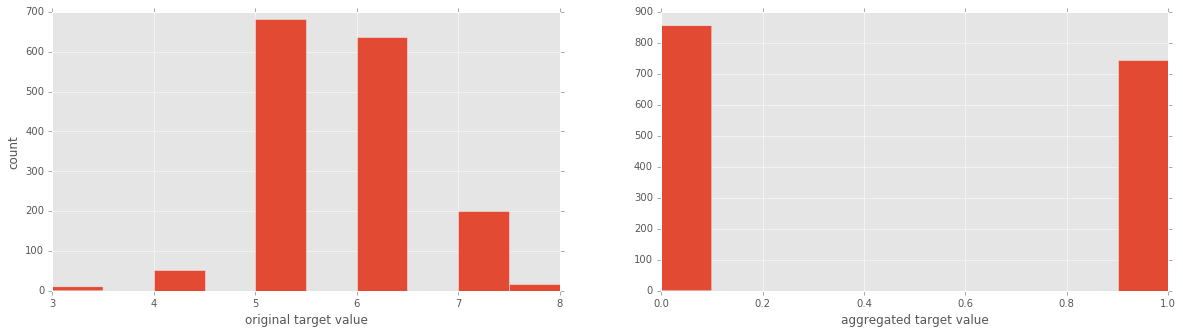

In [3]:
y = y1 <= 5 # is the rating <= 5?
# plot histograms of original target variable
# and aggregated target variable
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.hist(y1);
plt.xlabel('original target value')
plt.ylabel('count')
plt.subplot(1, 2, 2);
plt.hist(y)
plt.xlabel('aggregated target value')
plt.show()

Now we're nearly ready to perform k-nearest neighbours. First off, though, if we're going to compare how our model performs with and without preprocessing, we'll need to figure out how to measure the 'goodness' of a model:

#### K-nearest neighbours: how well does it perform?

There are a number of performance measures for classification challenges. It is of the utmost importance to realise that the choice of performance measure is deeply domain & question specific. In the case of a dataset with balanced classes (where all target values are ~ equally represented), data scientists commonly look at *accuracy* as a performance measure. In fact, as we'll see, accuracy is the default scoring method for both K-nearest neighbours and logistic regression in scikit-learn. So what is accuracy? It is merely the number of correct predictions divided by the total number of data points:

$$\text{Accuracy}=\frac{\text{Number of Correct Predictions}}{\text{Total Number of Data Points}}.$$

*Note: **accuracy** can also be defined in terms of a confusion matrix and is commonly defined for binary classification problems in terms of true positives & false negatives; other common measures of model performance derivable from the confusion matrix are **precision**, the number of true postives divided by the number of true & false postives, and **recall**, the number of true positives divided by the number of true positives plus the number of false negatives; yet another measure, the **F1-score** is the harmonic mean of the precision and the recall. See <a href='http://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/'>machine learning mastery</a> for a nice exposition of these measures; also check out the Wikipedia entries on the <a href='https://en.wikipedia.org/wiki/Confusion_matrix'>confusion matrix</a> and the <a href='https://en.wikipedia.org/wiki/F1_score'>F1 score</a>.*

#### K-nearest neighbours: performance in practice

It is all well and good to have a measure of performance such as accuracy, but if we fit the model on all of the data we have, what dataset are we going we going to report the accuracy from? Remember that we want a model that generalises well to new data. Thus, if we train our model on a dataset D, reporting the accuracy of the model on the same data D may make it look as though it performs better than it actually does. This is precisely the concept of **overfitting**. To combat this issue, data scientists will commonly train their model on a subset of the data, called the **training set** and evaulate its performance on the rest of the data, the **test set**. This is precisely what we're going to do here! A general rule of thumb is to use approximately 80% of the data for training & 20% for test. Let's now split our red wine quality data:

In [4]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We now build the K-NN model, make predictions on the test set and compare these predictions to the ground truth in order to get a measure of model performance:

In [5]:
from sklearn import neighbors, linear_model
knn = neighbors.KNeighborsClassifier(n_neighbors = 5)
knn_model_1 = knn.fit(X_train, y_train)
print('KNN accuracy for test set: %f' % knn_model_1.score(X_test, y_test))
print('KNN accuracy for training set: %f' % knn_model_1.score(X_train, y_train))

KNN accuracy for test set: 0.612500
KNN accuracy for training set: 0.774042


Notice, as is to be expected, that the accuracy is smaller on the test set than the training set. It is also worth mentioning that the default scoring method for K-NN in scikit-learn is *accuracy*. An accuracy of 61% is not great but for an out of the box model without any preprocessing it's not horiible either. To check out a variety of other metrics, we can use scikit-learn's classification report also: 

In [6]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test, knn_model_1.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

      False       0.66      0.64      0.65       179
       True       0.56      0.57      0.57       141

avg / total       0.61      0.61      0.61       320



Now we're going to introduce scaling and centering, the most basic methods of preprocessing numerical data, and see if and how they effect our model performance:

### The mechanics of preprocessing: scaling and centering

Before running a model, such as regression (predicting a continuous variable) or clustering (predicing a discrete variable), on data, you almost always want to do some preprocessing. For numerical variables, it is common to either *normalize* or *standardize* your data. What do these terms mean?

All *normalization* means is scaling a dataset so that its minimum is 0 and its maximum 1. To achieve this we transform each data point $x$ to

$$x_{normalized} = \frac{x-x_{min}}{x_{max}-x_{min}}.$$

*Stardardization* is slightly different; it's job is to centre the data around 0 and to scale with respect to the standard deviation:

$$x_{standardized} = \frac{x-\mu}{\sigma},$$

where $\mu$ and $\sigma$ are the mean and standard deviation of the dataset, respectively. First note that these transformations merely change the range of the data and not the distribution. You may later wish to use any other nunmber of transforms, such as a log transform or a Box-Cox transform, to make your data look more Gaussian (like a bell-curve). But before we go further, it is important to ask the following questions: why do we scale our data? Are there times that it is more appropriate than others? For example, is it more important in classification problems than in regression? 

Let's first delve into classification challenges and see how scaling your data affects clustering methods when compared with regression methods in classification problems:

#### Preprocessing: scaling in practice

Here below we scale the data, use k-nearest neighbours and check the model performance:

In [7]:
from sklearn.preprocessing import scale
# from sklearn.preprocessing import StandardScaler
Xs = scale(X)
from sklearn.cross_validation import train_test_split
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
knn_model_2 = knn.fit(Xs_train, y_train)
print('KNN score for test set: %f' % knn_model_2.score(Xs_test, y_test))
print('KNN score for training set: %f' % knn_model_2.score(Xs_train, y_train))
y_true, y_pred = y_test, knn_model_2.predict(Xs_test)
print(classification_report(y_true, y_pred))

KNN score for test set: 0.712500
KNN score for training set: 0.814699
             precision    recall  f1-score   support

      False       0.72      0.79      0.75       179
       True       0.70      0.62      0.65       141

avg / total       0.71      0.71      0.71       320



All these measures improved by 0.1, which is significant! As hinted at above, before scaling there were a number of predictor variables with ranges of different order of magnitudes, meaning that one or two of them could dominate in the context of an algorithm such as K-NN. We'll now look at exactly the same question but use regression techniques to solve our classification problem.

### A brief introduction to regression

#### Linear regression

As mentioned above, regression is commonly used to predict the value of one numerical variable from that of another. For example, below we perform a linear regression on Boston housing data: in this case, the independent variable (x-axis) is the number of rooms and the dependent variable (y-axis) is the price. 

How does such a regression work? In brief, the mechanics are as follows: we wish to fit a model $y = ax + b$ to the data $(x_i,y_i)$, that is, we want to find the optimal $a$ and $b$, given the data. In the ordinary least squares (OLS, by far the most common) formulation, there is an assumption that the error will occur in the dependent variable. For this reason, the optimal $a$ and $b$ are found by minimizing
$$SSE = \sum_i (y_i - (ax_i + b))^2$$
and this optimization is commonly achieved using an algorithm known as gradient descent. Here we perform a simple linear regression of the Boston housing data:

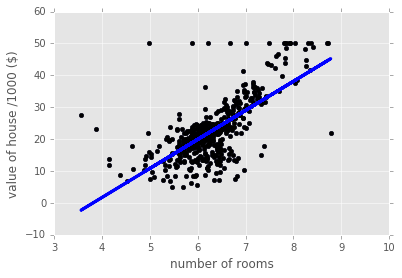

In [8]:
from sklearn import datasets
from sklearn import linear_model
import numpy as np
boston = datasets.load_boston()
yb = boston.target.reshape(-1, 1)
Xb = boston['data'][:,5].reshape(-1, 1)
plt.scatter(Xb,yb)
plt.ylabel('value of house /1000 ($)')
plt.xlabel('number of rooms')
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit( Xb, yb)
# Plot outputs
plt.scatter(Xb, yb,  color='black')
plt.plot(Xb, regr.predict(Xb), color='blue',
         linewidth=3)
plt.show()
# print(boston['DESCR'])

This regression captures the general increasing trend of the data but not much more. We have used only one predictor variable and could have used many more, in which case we would have $n$ coefficients $a_1,\ldots,a_n$ in the model, one for each predictor variable. It is worth noting that the magnitude of the variable $a_i$ tells us how strongly the corresponding variable is correlated with the target variable. 

#### Logistic regression

Regression can also be used for classification problems. The first natural example of this is **logistic regression**. In binary classifation (two labels), we can think of the labels as 0 & 1. Once again denoting the predictor variable as $x$, the logistic regression model is given by the logistic function
$$F(x) = \frac{1}{1+e^{-(ax+b)}}.$$
This is a sigmoidal (S-shaped) curved and you can see an example below. For any given $x$, if $F(x) <0.5$, then the logistic model predicts y = 0 and, alternatively, if $F(X) > 0.5$ the model predicts $y = 1$. Once again, in case we have more than one predictor variable, we also have $n$ coefficients $a_1,\ldots,a_n$, one for each predictor variable. In this case, the magnitude of the variable $a_i$ tells us how strongly the corresponding variable effects the predictor variable.

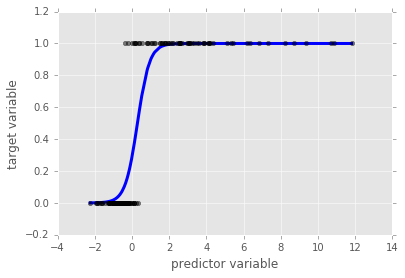

In [9]:
# Synthesize data
X1 = np.random.normal(size=150)
y1 = (X1 > 0).astype(np.float)
X1[X1 > 0] *= 4
X1 += .3 * np.random.normal(size=150)
X1= X1.reshape(-1, 1)
# run the classifier
clf = linear_model.LogisticRegression()
clf.fit(X1, y1)

X1_ordered = np.sort(X1 , axis = 0)
# and plot the result
plt.scatter(X1.ravel(), y1, color='black', zorder=20 , alpha = 0.5)
plt.plot(X1_ordered, clf.predict_proba(X1_ordered)[:,1], color='blue' , linewidth = 3)
plt.ylabel('target variable')
plt.xlabel('predictor variable')
plt.show()

### Logistic regression on the wine dataset

Now we've seen the mechanics of logistic regression, let's implement a a logistic regression classifier on our delicious win dataset:

In [10]:
# import necessary module
from sklearn import linear_model
# split data into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#initial logistic regression model
lr = linear_model.LogisticRegression()
# fit the model
lr = lr.fit(X_train, y_train)
print('KNN score for test set: %f' % lr.score(X_test, y_test))
print('KNN score for training set: %f' % lr.score(X_train, y_train))
from sklearn.metrics import classification_report
y_true, y_pred = y_test, lr.predict(X_test)
print(classification_report(y_true, y_pred))

KNN score for test set: 0.740625
KNN score for training set: 0.752932
             precision    recall  f1-score   support

      False       0.78      0.74      0.76       179
       True       0.69      0.74      0.71       141

avg / total       0.74      0.74      0.74       320



Out of the box, this logistic regression performs better than K-NN (with scaling). Lets now scale our data and perform logistic regression:

In [11]:
Xs = scale(X)
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
lr_2 = lr.fit(Xs_train, y_train)
print('KNN score for test set: %f' % lr_2.score(Xs_test, y_test))
print('KNN score for training set: %f' % lr_2.score(Xs_train, y_train))
y_true, y_pred = y_test, lr_2.predict(Xs_test)
print(classification_report(y_true, y_pred))

KNN score for test set: 0.740625
KNN score for training set: 0.752150
             precision    recall  f1-score   support

      False       0.79      0.74      0.76       179
       True       0.69      0.74      0.72       141

avg / total       0.74      0.74      0.74       320



This is very interesting! The performance of logistic regression did not improve with data scaling. Why not, particularly when we saw that K-nearest neigbours performance improved substantially with scaling? The reason is that, if there predictor variables with large ranges that do not effect the target variable, a regression algorithm will make the corrsponding coefficients $a_i$ small so that they do not effect predictions so much. K-nearest neighbours does not have such an inbuilt strategy and so we very much needed to scale the data.

### Coda, in which all of these concepts and practices are elucidated, using a synthetic dataset:

In order to see how data scaling affects classification challenges, we'll synthesize a dataset. This is a good approach so that we know exactly what is going on in it. In the code chunk below, we use scikit-learn's make_blobs function to generate 2000 data points that are in 4 clusters (each data point has 2 predictor variables and 1 target variable):

In [12]:
# Generate some clustered data (blobs!)
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
n_samples=2000
X, y = make_blobs(n_samples, centers=4, n_features=2,
                  random_state=0)
print('The shape of X is %s.' % str(X.shape))
print('The shape of y is %s.' % str(y.shape))

The shape of X is (2000, 2).
The shape of y is (2000,).


#### Plotting the synthesized data

We'll now plot in the plane the data that we've synthesized. Each axis is a predictor variable and the colour is a key to the target variable:

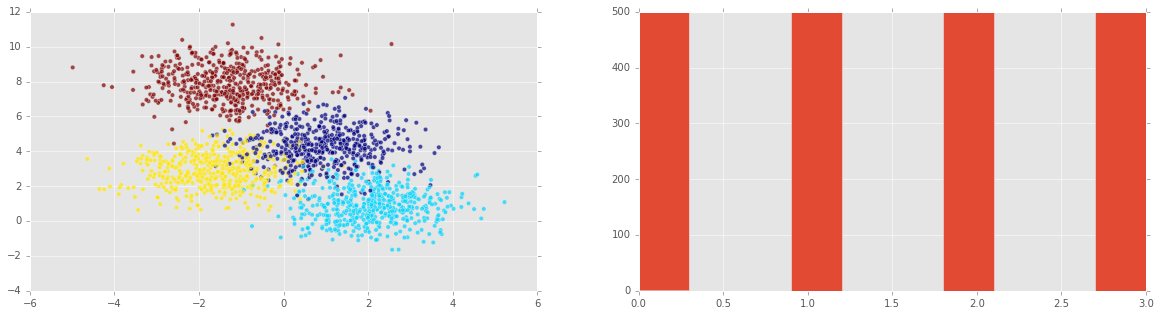

In [13]:
plt.style.use('ggplot') # Make the graphs a bit prettier
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.scatter(X[:,0] , X[:,1],  c = y, alpha = 0.7);
plt.subplot(1, 2, 2);
plt.hist(y)
plt.show()

*Note: we can see in the 2nd plot that all possible target variables are equally represented. In this case (or even if they are approximately equally represented), we say that the class y is balanced.*

I now want to plot histograms of the features (predictor variables). The easiest way to do this (that I know of) is converting numpy array to a pandas dataframe and calling pd.DataFrame.hist():

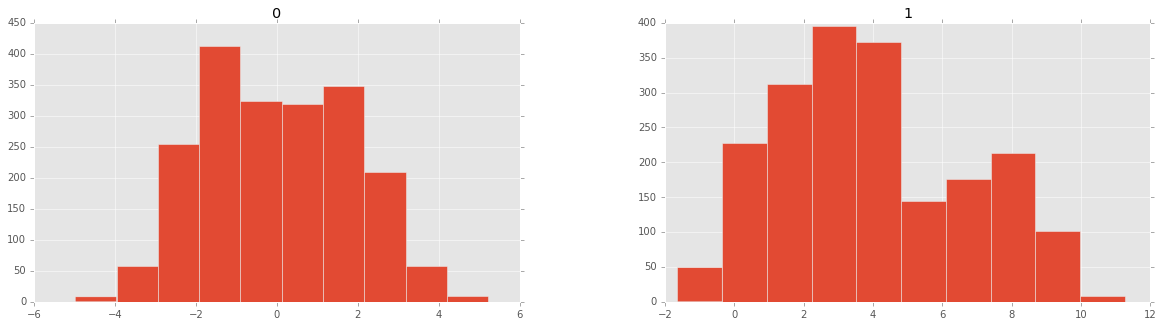

In [14]:
import pandas as pd
df = pd.DataFrame(X)
pd.DataFrame.hist(df, figsize=(20,5));

Let's now split into test/train & plot both sets:

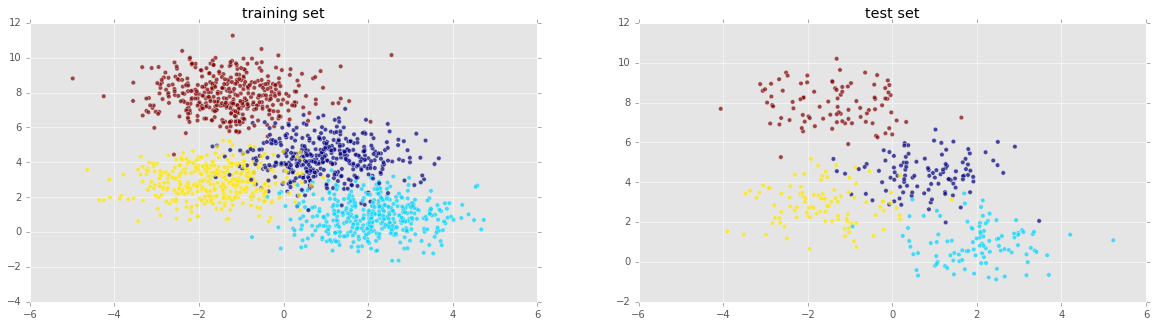

In [15]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.title('training set')
plt.scatter(X_train[:,0] , X_train[:,1],  c = y_train, alpha = 0.7);
plt.subplot(1, 2, 2);
plt.scatter(X_test[:,0] , X_test[:,1],  c = y_test, alpha = 0.7);
plt.title('test set')
plt.show()

Looking good! Now let's instantiate a k-nearest neighbors voting classifier and train it on our training set:

In [16]:
knn = neighbors.KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)

Now that we have trained our model we can fit it to our test set and compute the accuracy:

In [17]:
print('KNN score for test set: %f' % knn_model.score(X_test, y_test))

KNN score for test set: 0.935000


We can also re-fit it to our training set and compute the accuracy. We would expect it to perform better on the training set than the test set:

In [18]:
print('KNN score for training set: %f' % knn_model.score(X_train, y_train))

KNN score for training set: 0.941875


#### Now with scaling

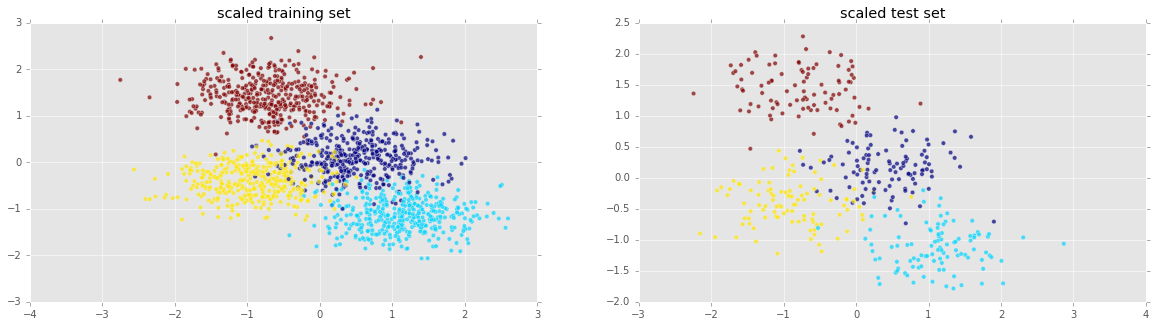

In [19]:
from sklearn.preprocessing import scale
# from sklearn.preprocessing import StandardScaler
Xs = scale(X)
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.scatter(Xs_train[:,0] , Xs_train[:,1],  c = y_train, alpha = 0.7);
plt.title('scaled training set')
plt.subplot(1, 2, 2);
plt.scatter(Xs_test[:,0] , Xs_test[:,1],  c = y_test, alpha = 0.7);
plt.title('scaled test set')
plt.show()

In [20]:
knn_model_s = knn.fit(Xs_train, y_train)
print('KNN score for test set: %f' % knn_model_s.score(Xs_test, y_test))

KNN score for test set: 0.935000


It doesn't perform any better. Probably because both features were already around the same range. It really makes sense to scale when variables have widely varying ranges. To see this in action, we're going to add another feature. Moreover, this feature will bear no relevance to the target variable: it will be mere noise.

#### Adding noise to the signal:

We add a third variable of Gaussian noise with mean 0 and variable standard deviation $\sigma$. We'll call $\sigma$ the strength of the noise and we'll see that the stronger the noise, the worse the performance of k-nearest neighbours.

In [21]:
# Add noise column to predictor variables
ns = 10**(3) # Strength of noise term
newcol = np.transpose([ns*np.random.randn(n_samples)])
Xn = np.concatenate((X, newcol), axis = 1)
print('The shape of the new feature array is %s.' % str(Xn.shape))

The shape of the new feature array is (2000, 3).


We'll now use the mplot3d package to plot the 3D data:

(-10000, 10000)

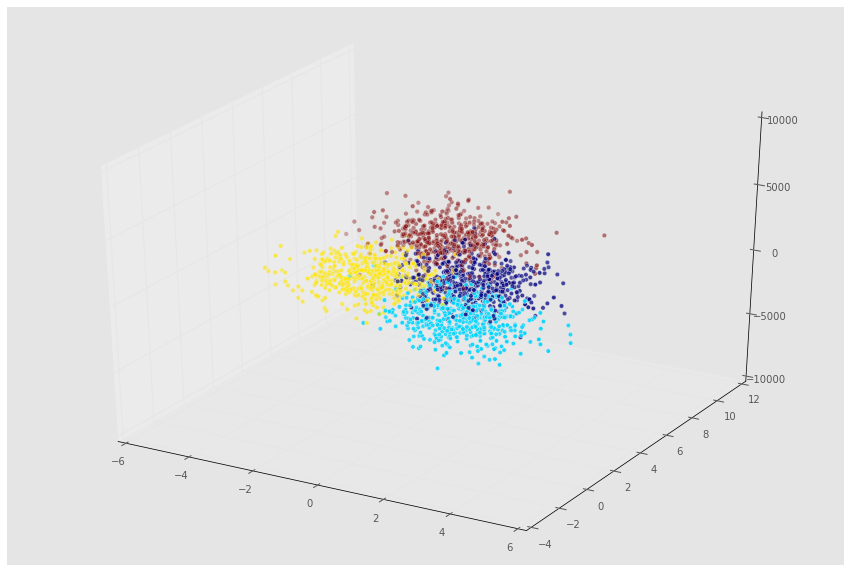

In [22]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10));
ax = fig.add_subplot(111, projection='3d' , alpha = 0.5);
ax.scatter(Xn[:,0], Xn[:,1], Xn[:,2], c = y);
ax.set_zlim((-10*ns,10*ns))

Now let's see how our model performs on the new data:

In [23]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size=0.2, random_state=42)
knn = neighbors.KNeighborsClassifier()
knn_model = knn.fit(Xn_train, y_train)
print('KNN score for test set: %f' % knn_model.score(Xn_test, y_test))

KNN score for test set: 0.322500


This is a horrible model! How about we scale and check out performance?

In [24]:
Xns = scale(Xn)
s = int(.2*n_samples)
Xns_train = Xns[s:]
y_train = y[s:]
Xns_test = Xns[:s]
y_test = y[:s]
knn = neighbors.KNeighborsClassifier()
knn_models = knn.fit(Xns_train, y_train)
print('KNN score for test set: %f' % knn_models.score(Xns_test, y_test))

KNN score for test set: 0.937500


Great, so after scaling the data, the model performs as well as were there no noise introduced. Let's now check out the model performance as a function of noise.

#### The stronger the noise, the bigger the problem:

We're now going to see how the noise strength effects model accuracy. As we'll need to use the same code a number of times, let's actually wrap up the main parts in a small function:

In [25]:
def accu( X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    knn = neighbors.KNeighborsClassifier()
    knn_model = knn.fit(X_train, y_train)
    return(knn_model.score(X_test, y_test))

In [26]:
noise = [10**i for i in np.arange(-1,6)]
A1 = np.zeros(len(noise))
A2 = np.zeros(len(noise))
count = 0
for ns in noise:
    newcol = np.transpose([ns*np.random.randn(n_samples)])
    Xn = np.concatenate((X, newcol), axis = 1)
    Xns = scale(Xn)
    A1[count] = accu( Xn, y)
    A2[count] = accu( Xns, y)
    count += 1

We now plot accuracy as a function of noise strength (note log x axis):

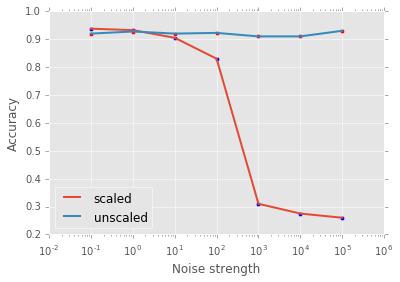

In [27]:
plt.scatter( noise, A1 )
plt.plot( noise, A1, label = 'scaled', linewidth = 2)
plt.scatter( noise, A2 , c = 'r')
plt.plot( noise, A2 , label = 'unscaled', linewidth = 2)
plt.xscale('log')
plt.xlabel('Noise strength')
plt.ylabel('Accuracy')
plt.legend(loc=3);

**Exercise for the avid reader:** try out fitting a logistic regression model to the above synthesized datasets and check out the model performance. How is accuracy a function of noise strength for scaled and unscaled data, respectively?

We have seen the essential place occupied in the data scietific pipeline by preprocessing, in its scaling and centering incarnation, and we have done so to promote a holistic approach to the challenges of machine learning. In future articles, I hope to extend this discussion to other types of preprocessing, such as transformations of numerical data and preprocessing of categorical data, both essential aspects of any data scientists's toolkit.